In [1]:
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uuid
import itertools

In [2]:
class World:
    def __init__(self,  agents, init_edge_proba=0, agent_power=3):
        self.G=nx.Graph()
        
        for agent in agents:
            self.G.add_node(agent)
            
        for target in self.G.nodes:
            for other in self.G.nodes:
                if target != other and random.random() < init_edge_proba:
                    self.G.add_edge(target, other)
                    
        self.history = {}
        self.step = 0
        self.agent_power = agent_power 
        
    def draw(self):
        
        ndict = dict(zip(self.G.nodes, [str(i.name) for i in self.G.nodes]))
        fig = plt.figure(figsize = (10,10))
        pos=nx.spring_layout(self.G)
        nx.draw(self.G, pos = pos)
        nx.draw_networkx_labels(self.G, pos=pos, labels=ndict)
        plt.show()
        
    def edge_evaluation(self, pred_a, pred_b):
        return (pred_a+pred_b)/2*random.uniform(0,2) > 0.5
        
    def selection(self):
        pass
        
    def distribute_power(self, dictionary):
        distributed = [i*self.agent_power/sum(dictionary.values()) for i in dictionary.values()]
        return(dict(zip(dictionary.keys(), distributed)))
    
    def update_history(self, step, **kwargs):
        self.history[step] = self.G.copy()
        
    def iterate(self, iterations, verbose=0, draw=False):
        for iteration in range(iterations):
            self.update_history(step=self.step)
            for agent in self.G.nodes:
                print(agent.name)
                agent.learn(self)
                agent.predict(self)
                agent.prediction_dict[self.step] = self.distribute_power(agent.predict(self))
                        
            for pair in itertools.combinations(self.G.nodes, 2):   
                try:
                    
                    if self.edge_evaluation(pair[0].prediction_dict[self.step][pair[1]],
                                            pair[1].prediction_dict[self.step][pair[0]]):

                        if pair not in self.G.edges:
                            self.G.add_edge(*pair)

                    elif pair in self.G.edges:
                        self.G.remove_edge(*pair)
                except KeyError:
                    print(pair)
                    print(pair[0].prediction_dict[self.step])
                    print(pair[1].prediction_dict[self.step])
                    return pair
            if draw:
                self.draw()
            
            self.selection()
            self.step += 1

In [3]:
def get_name(world, name):
    for i in world.G.nodes:
        if i.name == name:
            return i

In [4]:
class selectiveWorld(World):
    def __init__(self,  agents, init_edge_proba=0, agent_power=3, min_degs=1, selection_proba=0.2):
        World.__init__(self,  agents=agents, init_edge_proba=init_edge_proba, agent_power=agent_power)
        self.min_degs = min_degs
        self.selection_proba = selection_proba
    def selection(self):
        for node in list(self.G.nodes):
            if self.G.degree(node) < self.min_degs and random.random() < self.selection_proba:
                self.G.remove_node(node)
                
        

In [5]:
class AgentSkeleton:
    def __init__(self, name=None):
        self.prediction_dict = {}
         
        if name is None:
            self.name = '{}-{}'.format(''.join([i for i in self.__class__.__name__ if i.isupper() or i.isdigit()]), 
                                       str(uuid.uuid4())[:8])
        else: 
            self.name = name
            
    def learn(self, world):
        pass
    
    def predict(self, world):
        return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))
    
    def calculate_embeddedness(self, world):
        return world.centrality_dict[self]       
    

In [6]:
class GetBasedonDegree_v1(AgentSkeleton):
    def predict(self, world):
        centrality_dict = nx.degree_centrality(world.G)
        if sum(centrality_dict.values()) > 0:
            return centrality_dict
        else:
            return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))

In [7]:
class GetBasedonDegree_v2(AgentSkeleton):
    def predict(self, world):
        centrality_dict = nx.degree_centrality(world.G)
        if sum(centrality_dict.values()) > 0:
            return centrality_dict
        else:
            chosen = random.sample(list(world.G.nodes), world.agent_power)
            return dict(zip(list(world.G.nodes), [1 if i in chosen else 0 for i in list(world.G.nodes)]))

In [8]:
class GetBasedonDegree_V3(AgentSkeleton):
    def predict(self, world):
        centrality_dict = nx.degree_centrality(world.G)
        if sum(centrality_dict.values()) > 0:
            res = centrality_dict.copy()
            for key in res.keys():
                res[key] += 0.1
            return res
        else:
            return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))

In [9]:
class RegressorAgent(GetBasedonDegree_v1):
    def __init__(self, regressor, name=None):
        GetBasedonDegree_v1.__init__(self, name=name)
        self.regressor = regressor
        self.scaler = StandardScaler()
        self.colnames = ['DEGREE_CENTRALITY', 
                         'CLOSENESS_CENTRALITY', 
                         'SUBJECT_DEGREE_CENTRALITY', 
                         'SUBJECT_CLOSENESS_CENTRALITY'] 
    
    def _get_subject_data(self, snapshot, subject, target=None):
        learn_df = pd.DataFrame()
        learn_df['DEGREE_CENTRALITY'] = pd.Series(nx.degree_centrality(snapshot))
        learn_df['CLOSENESS_CENTRALITY'] = pd.Series(nx.closeness_centrality(snapshot))

        learn_df['SUBJECT_DEGREE_CENTRALITY'] = learn_df['DEGREE_CENTRALITY'][subject]
        learn_df['SUBJECT_CLOSENESS_CENTRALITY'] = learn_df['CLOSENESS_CENTRALITY'][subject]
            
        if target is not None:
            learn_df['TARGET'] = pd.Series(subject.prediction_dict[target])
            learn_df = learn_df.reset_index(drop=True)
                    
        return learn_df
        
    def _get_snapshot_data(self, snapshot, target=None):
        df_result = pd.DataFrame()
        for subject in snapshot.nodes:
            learn_df = self._get_subject_data(snapshot, subject, target)
            df_result = df_result.append(learn_df)
        return df_result
    
    def _data_preprocessing(self, history):
        df_learn_appended = pd.DataFrame()
        for step in list(history.keys())[:-1]:
            snapshot = history[step]
            df_learn_appended = df_learn_appended.append(self._get_snapshot_data(snapshot, target = step))
            df_learn_appended = df_learn_appended.fillna(0)
        pred_cols = [i for i in df_learn_appended.columns if i != 'TARGET']
        X = self.scaler.fit_transform(df_learn_appended[df_learn_appended.columns[1:]])
        y = df_learn_appended['TARGET'].values

        return X, y
            
    def learn(self, world):
        if len(world.history) > 1:
            X, y = self._data_preprocessing(world.history)
            self.regressor.fit(X, y)
        else:
            pass
        
    def predict(self, world):
        if len(world.history) > 1:
            input_df = self._get_subject_data(world.G, subject=self, target=None)
            X = self.scaler.transform(input_df.copy())
            pred = self.regressor.predict(X)
            result = dict(zip(input_df.index, pred))
            return result
        else:
            return GetBasedonDegree_v1.predict(self, world)
        

In [10]:
class GreedyRegressorAgent(RegressorAgent):
    def predict(self, world):
        edge_proba = RegressorAgent.predict(self, world)
        edge_value = dict(nx.closeness_centrality(world.G))
        result = {}
        for i in edge_proba.keys():
            result[i] = edge_proba[i]*(1+(edge_value[i]))

        return result

In [12]:
GreedyRegressorAgent(regressor=RandomForestRegressor()).regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

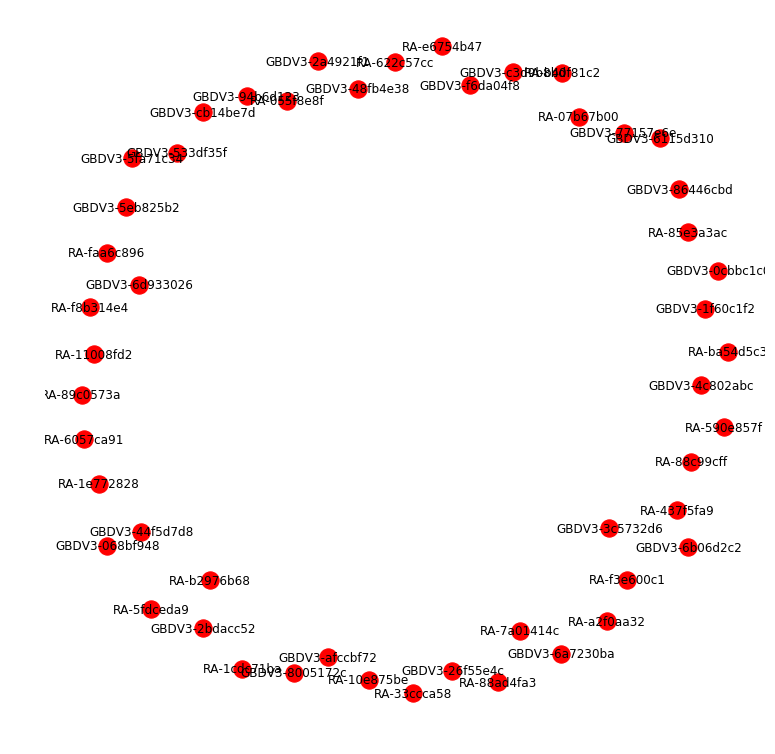

GBDV3-2bdacc52
GBDV3-5fa71c34
GBDV3-068bf948
GBDV3-6b06d2c2
GBDV3-3c5732d6
GBDV3-afccbf72
GBDV3-6d933026
GBDV3-48fb4e38
GBDV3-44f5d7d8
GBDV3-77157e6e
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-4c802abc
GBDV3-f6da04f8
GBDV3-cb14be7d
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-26f55e4c
GBDV3-6a7230ba
GBDV3-0cbbc1c0
GBDV3-c3d9b8bd
GBDV3-5eb825b2
GBDV3-6115d310
GBDV3-1f60c1f2
GBDV3-2a4921f1
RA-faa6c896
RA-1cdc71ba
RA-89c0573a
RA-1e772828
RA-88ad4fa3
RA-7a01414c
RA-85e3a3ac
RA-b40f81c2
RA-07b67b00
RA-33ccca58
RA-b2976b68
RA-f8b314e4
RA-622c57cc
RA-6057ca91
RA-11008fd2
RA-055f8e8f
RA-e6754b47
RA-10e875be
RA-590e857f
RA-88c99cff
RA-a2f0aa32
RA-437f5fa9
RA-5fdceda9
RA-f3e600c1
RA-ba54d5c3


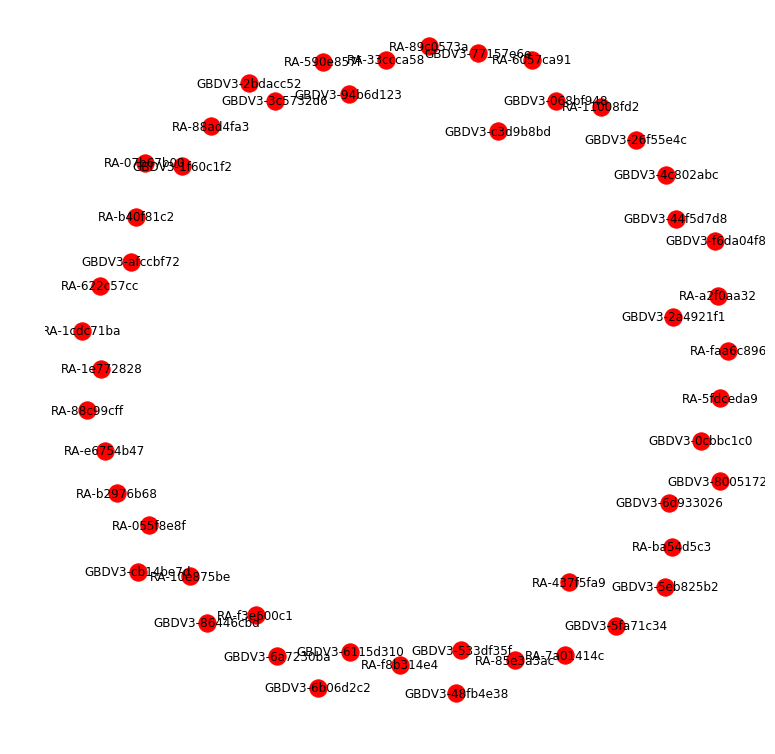

GBDV3-2bdacc52
GBDV3-5fa71c34
GBDV3-068bf948
GBDV3-6b06d2c2
GBDV3-3c5732d6
GBDV3-afccbf72
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-4c802abc
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-26f55e4c
GBDV3-6a7230ba
GBDV3-0cbbc1c0
GBDV3-c3d9b8bd
GBDV3-5eb825b2
GBDV3-6115d310
GBDV3-1f60c1f2
GBDV3-2a4921f1
RA-faa6c896
RA-89c0573a
RA-1e772828
RA-7a01414c
RA-85e3a3ac
RA-b40f81c2
RA-33ccca58
RA-b2976b68
RA-f8b314e4
RA-622c57cc
RA-6057ca91
RA-055f8e8f
RA-10e875be
RA-437f5fa9
RA-5fdceda9
RA-f3e600c1


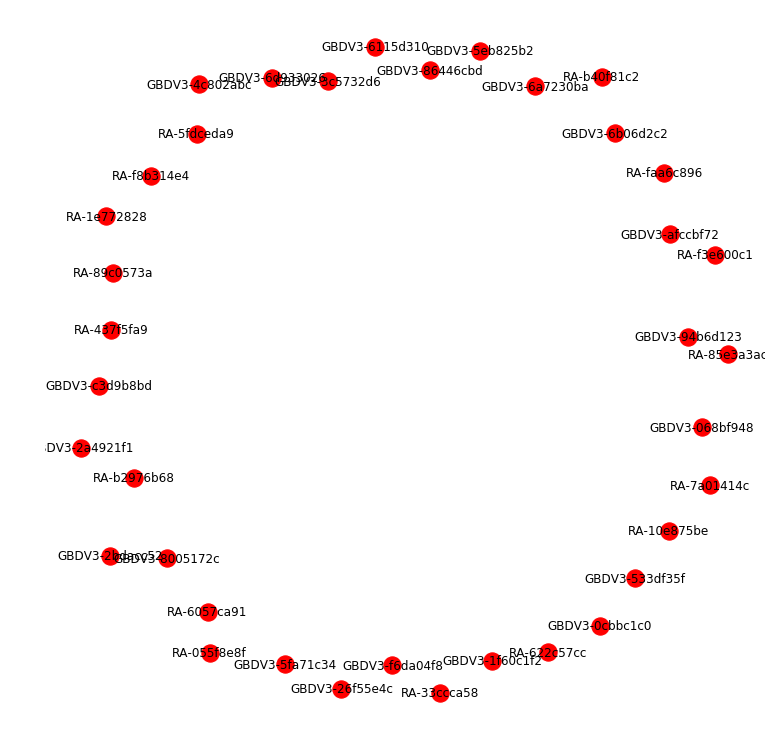

GBDV3-2bdacc52
GBDV3-6b06d2c2
GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-26f55e4c
GBDV3-6a7230ba
GBDV3-0cbbc1c0
GBDV3-c3d9b8bd
GBDV3-5eb825b2
GBDV3-1f60c1f2
GBDV3-2a4921f1
RA-faa6c896
RA-89c0573a
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-6057ca91
RA-055f8e8f
RA-10e875be
RA-437f5fa9
RA-f3e600c1


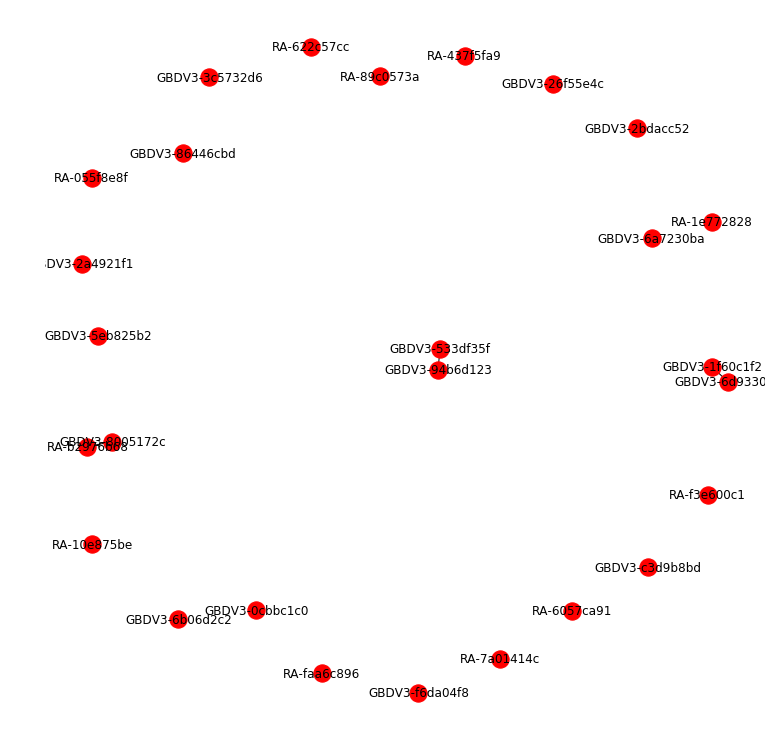

GBDV3-2bdacc52
GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-26f55e4c
GBDV3-0cbbc1c0
GBDV3-c3d9b8bd
GBDV3-5eb825b2
GBDV3-1f60c1f2
RA-faa6c896
RA-89c0573a
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f
RA-437f5fa9
RA-f3e600c1


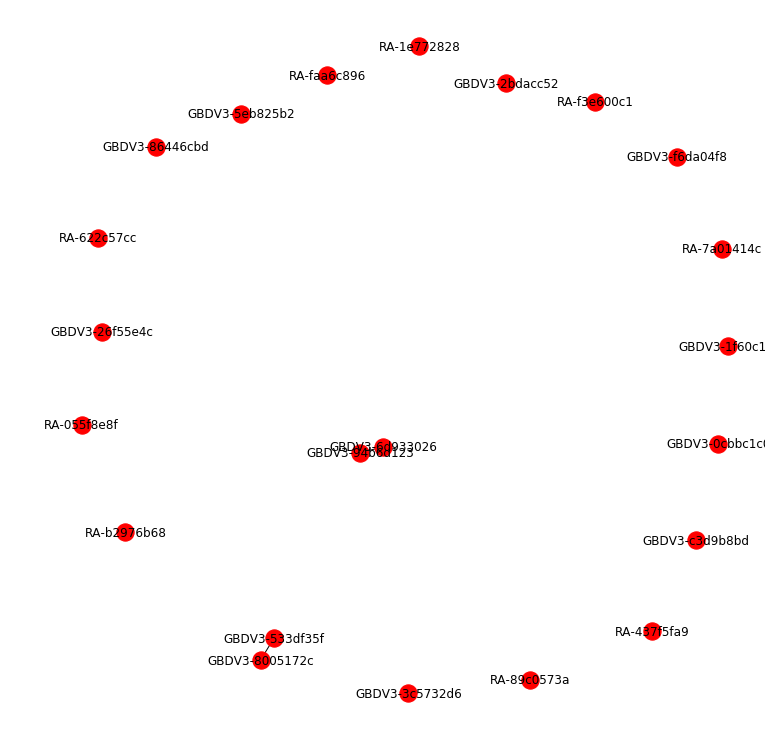

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


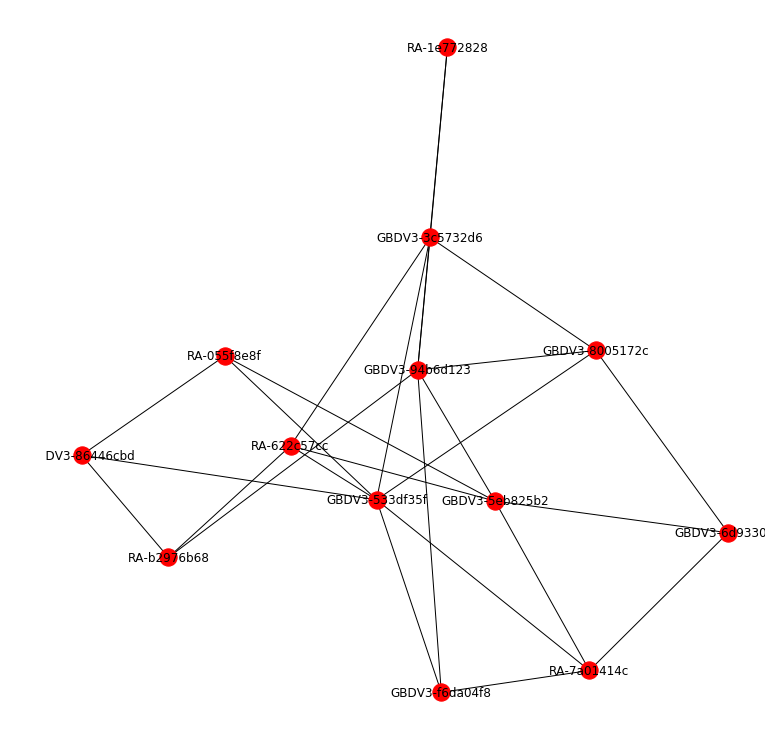

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


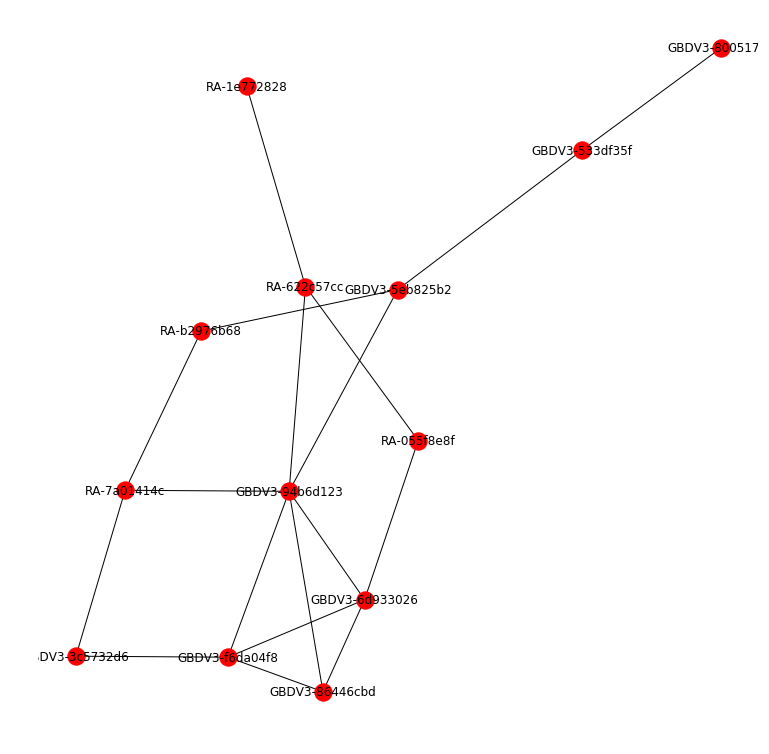

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


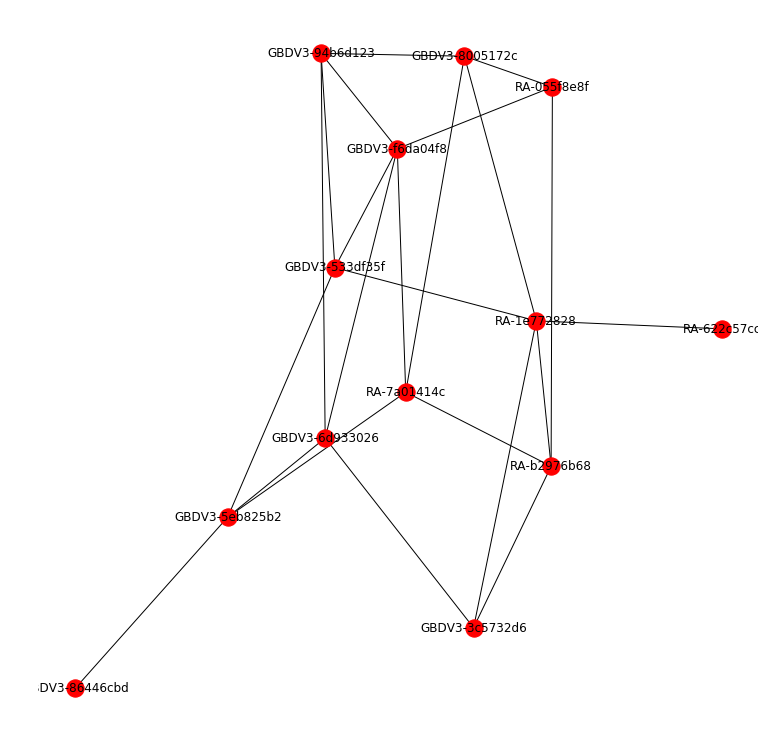

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


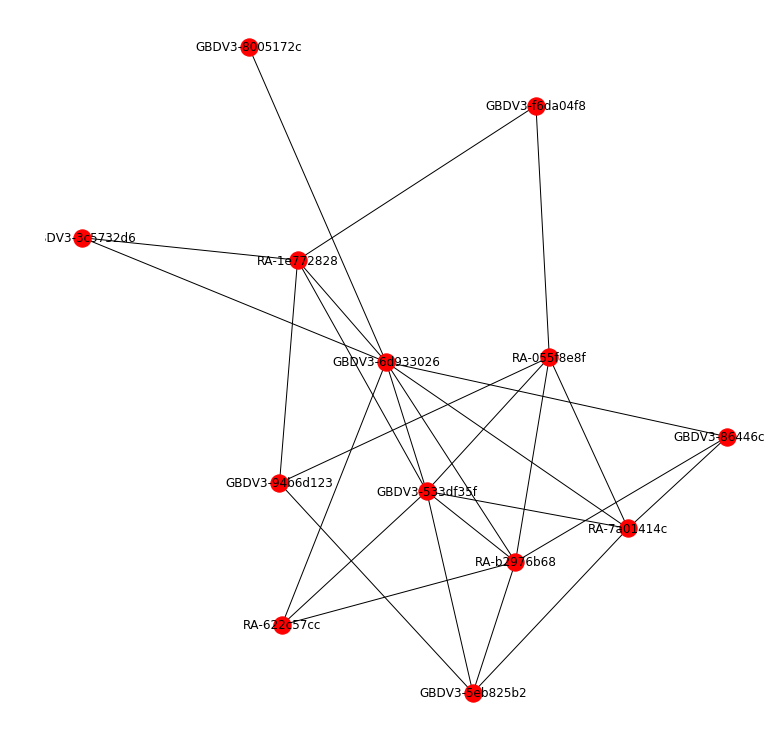

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


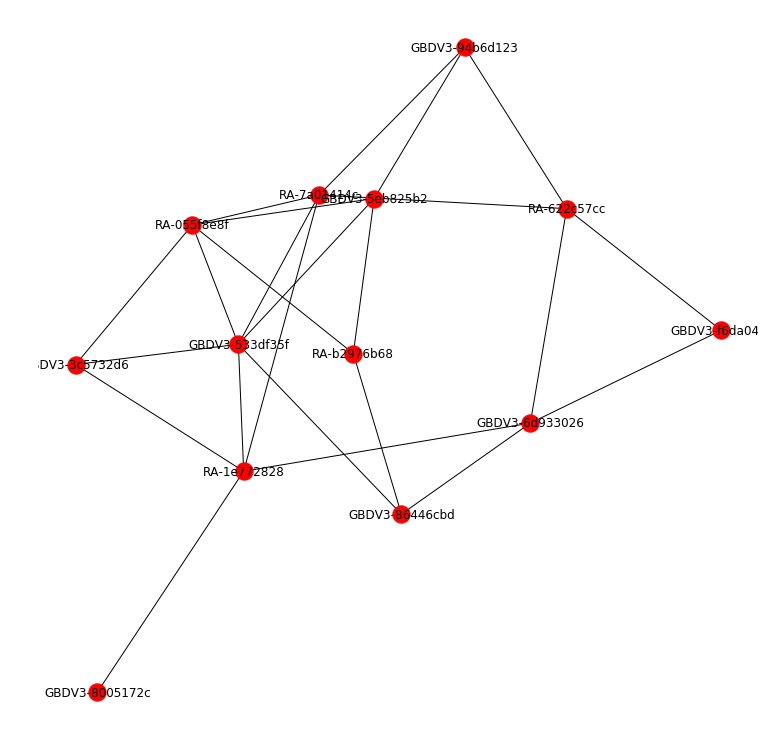

GBDV3-3c5732d6
GBDV3-6d933026
GBDV3-8005172c
GBDV3-86446cbd
GBDV3-f6da04f8
GBDV3-533df35f
GBDV3-94b6d123
GBDV3-5eb825b2
RA-1e772828
RA-7a01414c
RA-b2976b68
RA-622c57cc
RA-055f8e8f


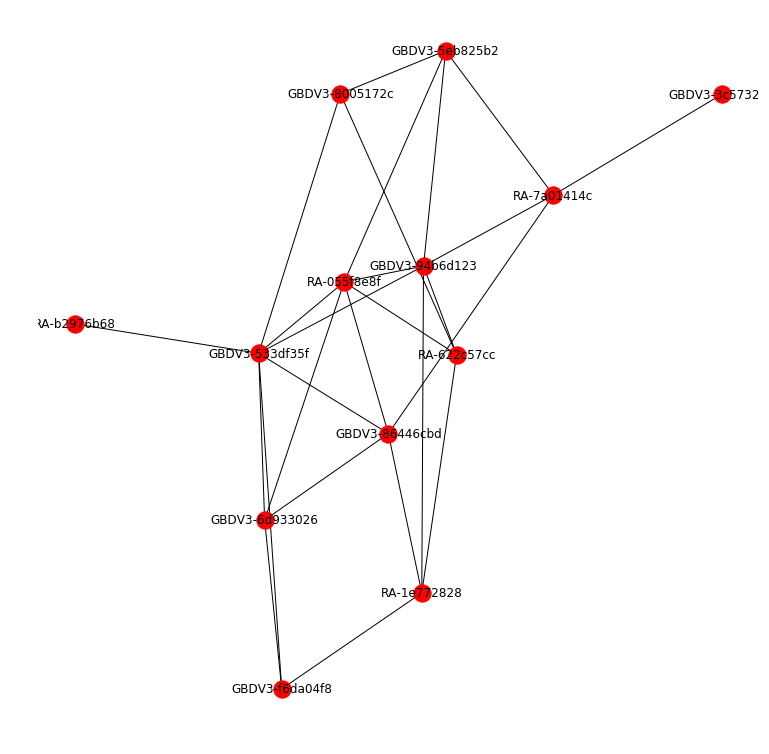

In [24]:
agents = []
agents += [GetBasedonDegree_V3() for i in range(25)]
agents += [RegressorAgent(regressor=RandomForestRegressor()) for i in range(25)]
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.3)
test_world.draw()
test_world.iterate(10, draw = True)

In [27]:
subject = get_name(test_world, 'RA-055f8e8f')
subject.colnames = ['DEGREE_CENTRALITY', 
                    'CLOSENESS_CENTRALITY', 
                    'SUBJECT_DEGREE_CENTRALITY', 
                    'SUBJECT_CLOSENESS_CENTRALITY'] 

for col, coef in zip(subject.colnames, subject.regressor.feature_importances_):
    print(col, '%f' % coef)

DEGREE_CENTRALITY 0.000119
CLOSENESS_CENTRALITY 0.000000
SUBJECT_DEGREE_CENTRALITY 0.000047
SUBJECT_CLOSENESS_CENTRALITY 0.999834


In [28]:
subject.prediction_dict

{0: {<__main__.GetBasedonDegree_V3 at 0x2448f166c88>: 0.056913910150678405,
  <__main__.GetBasedonDegree_V3 at 0x2448f166b38>: 0.15353059273367636,
  <__main__.GetBasedonDegree_V3 at 0x2448e807470>: 0.05593432044389111,
  <__main__.GetBasedonDegree_V3 at 0x2448e807748>: 0.08855548349228991,
  <__main__.GetBasedonDegree_V3 at 0x2448e8075c0>: 0.14512569701751737,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c128>: 0.180084583919178,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c748>: 0.09713017441514003,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c198>: 0.0882133852904908,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c668>: 0.20446713252660045,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c2e8>: 0.035591391618968994,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c7b8>: 0.06421185494717599,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c3c8>: 0.15899311558998097,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c0f0>: 0.09280879327366927,
  <__main__.GetBasedonDegree_V3 at 0x2448ea5c4a8>: 0.111711258